In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import time
from datetime import datetime, date, timedelta
import tweepy
from dotenv import load_dotenv
import preprocessor as p
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
import stanza
stanza.download('en')
from pycorenlp import StanfordCoreNLP

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/manoj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2021-08-06 11:34:35 INFO: Downloading default packages for language: en (English)...


2021-08-06 11:34:36 INFO: File exists: /Users/manoj/stanza_resources/en/default.zip.
2021-08-06 11:34:39 INFO: Finished downloading models and saved to /Users/manoj/stanza_resources.


In [2]:
SA = pd.read_csv("/Users/manoj/Desktop/Final Project/vaccination_all_tweets.csv")
SA.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [3]:
SA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88978 entries, 0 to 88977
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                88978 non-null  int64 
 1   user_name         88978 non-null  object
 2   user_location     68661 non-null  object
 3   user_description  82449 non-null  object
 4   user_created      88978 non-null  object
 5   user_followers    88978 non-null  int64 
 6   user_friends      88978 non-null  int64 
 7   user_favourites   88978 non-null  int64 
 8   user_verified     88978 non-null  bool  
 9   date              88978 non-null  object
 10  text              88978 non-null  object
 11  hashtags          70306 non-null  object
 12  source            88859 non-null  object
 13  retweets          88978 non-null  int64 
 14  favorites         88978 non-null  int64 
 15  is_retweet        88978 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 9.7+ MB


In [4]:
SA.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,8.897800e+04,8.897800e+04,88978.000000,8.897800e+04,88978.000000,88978.000000
mean,1.377373e+18,1.066402e+05,1234.492268,1.544847e+04,3.302007,14.564061
std,1.351614e+16,8.576584e+05,5654.167170,4.486281e+04,63.793619,220.749262
min,1.337728e+18,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.367877e+18,1.010000e+02,135.000000,3.150000e+02,0.000000,0.000000
50%,1.378005e+18,5.060000e+02,378.000000,2.151000e+03,0.000000,1.000000
75%,1.384769e+18,2.450000e+03,1083.000000,1.105750e+04,1.000000,3.000000
max,1.399687e+18,1.556950e+07,516578.000000,1.221784e+06,11288.000000,25724.000000


In [5]:
SA_final = SA[(SA['text'].str.contains("vacc")) 
                            | (SA['text'].str.contains("Vacc"))
                            | (SA['hashtags'].str.contains("vacc"))
                            | (SA['hashtags'].str.contains("Vacc"))]
len(SA_final)

49966

In [6]:
#Text Pre-processing

In [7]:
SA = SA_final.copy()

In [8]:
SA['text_cleaned'] = SA['text'].apply(lambda x: p.clean(x))

In [9]:
SA.drop_duplicates(subset='text_cleaned', keep="first", inplace = True)
len(SA)

46431

In [10]:
punct =['%','/',':','\\','&amp;','&',';']

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

SA['text_cleaned'] = SA['text_cleaned'].apply(lambda x: remove_punctuations(x))

In [11]:
# Drop tweets which have empty text field
SA['text_cleaned'].replace('', np.nan, inplace=True)
SA['text_cleaned'].replace(' ', np.nan, inplace=True)
SA.dropna(subset=['text_cleaned'], inplace=True)
len(SA)

46429

In [12]:
SA = SA.reset_index(drop=True)
SA.sample(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,text_cleaned
41201,1393044297444851713,DT Next,"Chennai, India",English language newspaper by the Daily Thanth...,2015-10-23 12:33:47,8791,430,153,True,2021-05-14 03:23:36,Are the state governments setting the right pr...,NaN,Twitter Web App,0,0,False,Are the state governments setting the right pr...
33282,1381808354100617218,Nitendra Singh नितेन्द्र सिंह,New Delhi,"Works at @DDNewsLive. Covers #Health, #Publicp...",2012-02-13 05:54:17,1975,1196,44270,False,2021-04-13 03:15:59,"Central drug regulator, #DCGI has approved eme...","['DCGI', 'SputnikV']",Twitter for Android,1,3,False,"Central drug regulator, has approved emergency..."
23309,1376388577374916609,usama malik,New Delhi india,NaN,2012-12-24 09:56:42,27,102,302,False,2021-03-29 04:19:43,@ndtv Now where is our vaccine? Why corona is ...,NaN,Twitter for iPhone,0,0,False,Now where is our vaccine? Why corona is spread...
11713,1367118212039667712,Christopher Marrone,NYC Metro & South Florida,Financial Professional with New York Life help...,2020-09-10 15:22:56,14,6,2,False,2021-03-03 14:22:36,3. The #COVID #vaccine developed by China’s #S...,"['COVID', 'vaccine', 'Sinovac']",Twitter Web App,0,0,False,. The developed by Chinas Biotech has an effic...
32817,1382056271478542336,Prescilla Rodrigues,"Mumbai, India","Human at heart.. Views, comments and RT's are ...",2015-11-13 14:52:23,95,227,11,False,2021-04-13 19:41:07,@mybmc Thanks for the update. Of ths hospitals...,NaN,Twitter for Android,1,1,False,"Thanks for the update. Of ths hospitals, can w..."


In [13]:
#Sentiment Analysis

In [14]:
# Define function to get value counts
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(SA[col_name].value_counts())
    percentage = pd.DataFrame(SA[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

In [15]:
#Sentiment Analysis with NLTK Vaderi 

In [16]:
sia = SentimentIntensityAnalyzer()
SA['nltk_scores'] = SA['text_cleaned'].apply(lambda x: sia.polarity_scores(x))
SA['nltk_cmp_score'] = SA['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

In [17]:
neutral_thresh = 0.05

In [18]:
# Categorize scores into the sentiments of positive, neutral or negative
SA['nltk_sentiment'] = SA['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [19]:
SA['nltk_cmp_score'].describe()

count    46429.000000
mean         0.108031
std          0.341492
min         -0.959900
25%          0.000000
50%          0.000000
75%          0.401900
max          0.968200
Name: nltk_cmp_score, dtype: float64

In [20]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,7355,15.84,NLTK Vader
1,Neutral,22240,47.90,NLTK Vader
2,Positive,16834,36.26,NLTK Vader


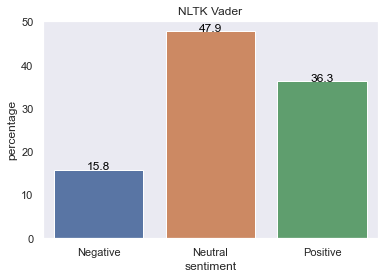

In [21]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=nltk_sentiment_df)
ax.set_title('NLTK Vader')

for index, row in nltk_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

In [22]:
#Sentiment Analysis with TextBlob

In [23]:
# Obtain polarity scores generated by TextBlob
SA['textblob_score'] = SA['text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [24]:
neutral_thresh = 0.05

In [25]:
# Convert polarity score into sentiment categories
SA['textblob_sentiment'] = SA['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

In [26]:
SA['textblob_score'].describe()

count    46429.000000
mean         0.109092
std          0.240994
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.250000
max          1.000000
Name: textblob_score, dtype: float64

In [27]:
textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob')
textblob_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,4543,9.78,TextBlob
1,Neutral,23342,50.27,TextBlob
2,Positive,18544,39.94,TextBlob


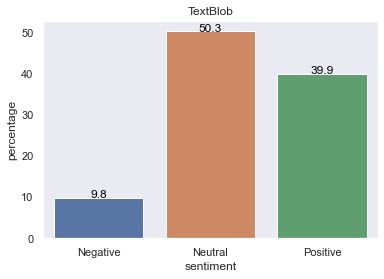

In [28]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
ax.set_title('TextBlob')

for index, row in textblob_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

In [29]:
train= pd.DataFrame()
train['text_cleaned']= SA['text_cleaned']

In [30]:
train=train.dropna()

In [31]:
train.isnull().sum()

text_cleaned    0
dtype: int64

In [32]:
#Importing the BERT Tokenizer

In [33]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [34]:
print(tokenizer.tokenize("Coronavirus mutations being tracked, new vaccine"))

['corona', '##virus', 'mutations', 'being', 'tracked', ',', 'new', 'vaccine']


In [35]:
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Coronavirus mutations being tracked, new vaccine")))

[21887, 23350, 14494, 2108, 12808, 1010, 2047, 17404]


In [36]:
max_len = 0
for tweet in train['text_cleaned']:
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tweet = url_pattern.sub(r'', tweet)
    tweet = re.sub('\S*@\S*\s?', '', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    tweet = re.sub("\'", "", tweet)
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    print('Max sequence length: ', max_len)

Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27
Max sequence length:  27


Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34
Max sequence length:  34


Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35


Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35
Max sequence length:  35


Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37


Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37


Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37
Max sequence length:  37


Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41


Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41


Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41
Max sequence length:  41


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43
Max sequence length:  43


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47
Max sequence length:  47


In [37]:
SA.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,source,retweets,favorites,is_retweet,text_cleaned,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment
0,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,...,Twitter Web App,1,1,False,While the world has been on the wrong side of ...,"{'neg': 0.13, 'neu': 0.756, 'pos': 0.113, 'com...",-0.1027,Negative,-0.5,Negative
1,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,...,Twitter for Android,0,0,False,Russian vaccine is created to last -4 years,"{'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...",0.2500,Positive,0.0,Neutral
2,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,...,Twitter for iPhone,0,0,False,Explain to me again why we need a vaccine,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.0,Neutral
3,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,...,Twitter for iPhone,0,0,False,Does anyone have any useful adviceguidance for...,"{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'comp...",0.7003,Positive,0.4,Positive
4,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,...,Twitter Web App,0,4,False,it is a bit sad to claim the fame for success ...,"{'neg': 0.121, 'neu': 0.623, 'pos': 0.257, 'co...",0.5423,Positive,-0.1,Negative


In [38]:
#NLTK Sentiment Analysis - TfidfTransformer

In [39]:
SA_New=SA[['text_cleaned', 'nltk_sentiment']]
SA_New.head()

,text_cleaned,nltk_sentiment
0,While the world has been on the wrong side of ...,Negative
1,Russian vaccine is created to last -4 years,Positive
2,Explain to me again why we need a vaccine,Neutral
3,Does anyone have any useful adviceguidance for...,Positive
4,it is a bit sad to claim the fame for success ...,Positive


In [40]:
# one hot encoding
one_hot = pd.get_dummies(SA_New["nltk_sentiment"])
SA_New.drop(['nltk_sentiment'],axis=1,inplace=True)
SA_New = pd.concat([SA_New,one_hot],axis=1)
SA_New.head()

/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,text_cleaned,Negative,Neutral,Positive
0,While the world has been on the wrong side of ...,1,0,0
1,Russian vaccine is created to last -4 years,0,0,1
2,Explain to me again why we need a vaccine,0,1,0
3,Does anyone have any useful adviceguidance for...,0,0,1
4,it is a bit sad to claim the fame for success ...,0,0,1


In [41]:
#Train Test Split

In [42]:
from sklearn.model_selection import train_test_split
X=SA_New['text_cleaned'].values
y=SA_New.drop('text_cleaned', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [44]:
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

In [45]:
#Build the Model -- RNN

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [47]:
X_train.shape

(32500, 20469)

In [48]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [50]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
127/127 [==============================] - 301s 2s/step - loss: 0.7310 - accuracy: 0.6685 - val_loss: 0.3897 - val_accuracy: 0.8624
Epoch 2/100
127/127 [==============================] - 293s 2s/step - loss: 0.1647 - accuracy: 0.9455 - val_loss: 0.3837 - val_accuracy: 0.8748
Epoch 3/100
127/127 [==============================] - 279s 2s/step - loss: 0.0569 - accuracy: 0.9839 - val_loss: 0.4611 - val_accuracy: 0.8782
Epoch 4/100
127/127 [==============================] - 271s 2s/step - loss: 0.0224 - accuracy: 0.9942 - val_loss: 0.5730 - val_accuracy: 0.8680
Epoch 00004: early stopping


In [51]:
#Evaluation

In [52]:
SA_New_m=pd.DataFrame(model.history.history)
SA_New_m['Epoch']=range(1,5)
SA_New_m.index=SA_New_m['Epoch']
SA_New_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.561739,0.771508,0.389659,0.862373,1
2,0.160617,0.947385,0.383688,0.874794,2
3,0.055460,0.984031,0.461106,0.878240,3
4,0.024059,0.993538,0.572964,0.867973,4


In [53]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

218/218 [==============================] - 46s 208ms/step - loss: 0.5730 - accuracy: 0.8680
Test accuracy: 0.867973268032074


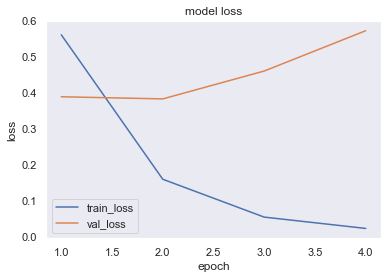

In [54]:
#Loss Graph(Training and Validation)
plt.plot(SA_New_m['loss'])
plt.plot(SA_New_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

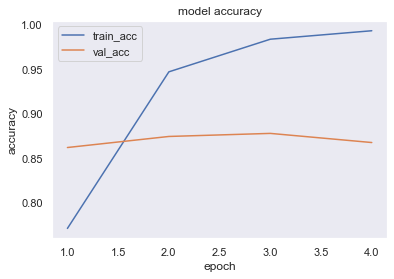

In [55]:
# Accuracy Graph(Training and Validation) 
plt.plot(SA_New_m['accuracy'])
plt.plot(SA_New_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [56]:
preds = model.predict(X_test)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

[[1418  482  258]
 [ 111 6387  204]
 [ 231  553 4285]]
              precision    recall  f1-score   support

           0       0.81      0.66      0.72      2158
           1       0.86      0.95      0.90      6702
           2       0.90      0.85      0.87      5069

    accuracy                           0.87     13929
   macro avg       0.86      0.82      0.83     13929
weighted avg       0.87      0.87      0.87     13929



In [58]:
#NLTK Sentiment Analysis - SVM-SGD, Navie Bayes, Bernoulli Naive Bayes, Logistic Regression, SVM, Decision Tree

In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [60]:
SA_New_ML=SA[['text_cleaned', 'nltk_sentiment']]
SA_New_ML.head()

,text_cleaned,nltk_sentiment
0,While the world has been on the wrong side of ...,Negative
1,Russian vaccine is created to last -4 years,Positive
2,Explain to me again why we need a vaccine,Neutral
3,Does anyone have any useful adviceguidance for...,Positive
4,it is a bit sad to claim the fame for success ...,Positive


In [61]:
from sklearn.model_selection import train_test_split
X=SA_New_ML['text_cleaned'].values
y=SA_New_ML.drop('text_cleaned', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [63]:
model_prediction = dict()

In [64]:
# SVM - Stochastic Gradient Descent
model = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber").fit(X_train, y_train)
model_prediction['SVM-SGD'] = model.predict(X_test)

# Multinomial Naive Bayes
model = MultinomialNB().fit(X_train, y_train)
model_prediction['Multinomial'] = model.predict(X_test)

# Bernoulli Naive Bayes
model = BernoulliNB().fit(X_train, y_train)
model_prediction['Bernoulli'] = model.predict(X_test)

# Logistic Regression
model = LogisticRegression(C=1).fit(X_train, y_train)
model_prediction['Logistic'] = model.predict(X_test)

# SVM - Support Vector Classifier
model = SVC(gamma='auto', C=1).fit(X_train, y_train)
model_prediction['SVM'] = model.predict(X_test)

# Decision Trees
model = DecisionTreeClassifier().fit(X_train, y_train)
model_prediction['Decision Tree'] = model.predict(X_test)

/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [65]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
print("ACCURACY SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(accuracy_score(y_test, model_prediction[model_name])*100, 2))

ACCURACY SCORE:

SVM-SGD :  90.53
Multinomial :  78.18
Bernoulli :  79.14
Logistic :  88.81
SVM :  48.12
Decision Tree :  82.36


In [67]:
#Textblob Sentiment Analysis

In [68]:
SA_New_Text=SA[['text_cleaned', 'textblob_sentiment']]
SA_New_Text.head()

,text_cleaned,textblob_sentiment
0,While the world has been on the wrong side of ...,Negative
1,Russian vaccine is created to last -4 years,Neutral
2,Explain to me again why we need a vaccine,Neutral
3,Does anyone have any useful adviceguidance for...,Positive
4,it is a bit sad to claim the fame for success ...,Negative


In [69]:
# one hot encoding
one_hot = pd.get_dummies(SA_New_Text["textblob_sentiment"])
SA_New_Text.drop(['textblob_sentiment'],axis=1,inplace=True)
SA_New_Text = pd.concat([SA_New_Text,one_hot],axis=1)
SA_New_Text.head()

/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,text_cleaned,Negative,Neutral,Positive
0,While the world has been on the wrong side of ...,1,0,0
1,Russian vaccine is created to last -4 years,0,1,0
2,Explain to me again why we need a vaccine,0,1,0
3,Does anyone have any useful adviceguidance for...,0,0,1
4,it is a bit sad to claim the fame for success ...,1,0,0


In [70]:
#Train Test Split

In [71]:
from sklearn.model_selection import train_test_split
X=SA_New_Text['text_cleaned'].values
y=SA_New_Text.drop('text_cleaned', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [73]:
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

In [74]:
#Build the Model -- RNN

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [76]:
X_train.shape

(32500, 20469)

In [77]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [79]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
127/127 [==============================] - 288s 2s/step - loss: 0.6857 - accuracy: 0.6958 - val_loss: 0.3087 - val_accuracy: 0.8899
Epoch 2/100
127/127 [==============================] - 290s 2s/step - loss: 0.1482 - accuracy: 0.9501 - val_loss: 0.3073 - val_accuracy: 0.8958
Epoch 3/100
127/127 [==============================] - 310s 2s/step - loss: 0.0621 - accuracy: 0.9778 - val_loss: 0.3923 - val_accuracy: 0.8983
Epoch 4/100
127/127 [==============================] - 322s 3s/step - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.4186 - val_accuracy: 0.8950
Epoch 00004: early stopping


In [80]:
#Evaluation

In [81]:
SA_New_Text_m=pd.DataFrame(model.history.history)
SA_New_Text_m['Epoch']=range(1,5)
SA_New_Text_m.index=SA_New_Text_m['Epoch']
SA_New_Text_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.510981,0.796062,0.308682,0.889870,1
2,0.144715,0.949415,0.307304,0.895757,2
3,0.059018,0.979108,0.392349,0.898342,3
4,0.032395,0.989508,0.418579,0.894967,4


In [82]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', score[1])

218/218 [==============================] - 55s 249ms/step - loss: 0.4186 - accuracy: 0.8950
Test accuracy: 0.8949673175811768


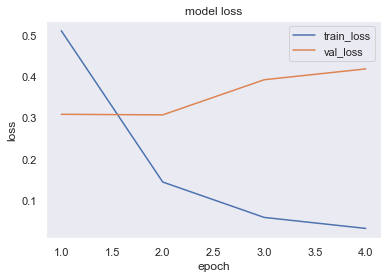

In [83]:
#Loss Graph(Training and Validation)
plt.plot(SA_New_Text_m['loss'])
plt.plot(SA_New_Text_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

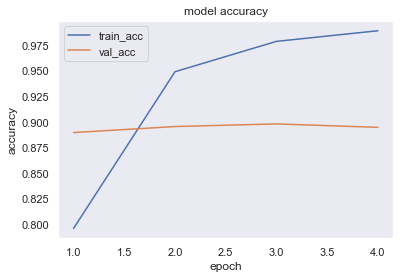

In [84]:
# Accuracy Graph(Training and Validation) 
plt.plot(SA_New_Text_m['accuracy'])
plt.plot(SA_New_Text_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [85]:
preds = model.predict(X_test)

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

[[ 849  386   93]
 [ 128 6480  380]
 [  59  417 5137]]
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      1328
           1       0.89      0.93      0.91      6988
           2       0.92      0.92      0.92      5613

    accuracy                           0.89     13929
   macro avg       0.87      0.83      0.85     13929
weighted avg       0.89      0.89      0.89     13929



In [87]:
#Textblob Sentiment Analysis - SVM-SGD, Naive Bayes, Bernoulli Naive Bayes, Logistic Regression, SVM, Decision Tree

In [88]:
SA_New_Text_ML=SA[['text_cleaned', 'textblob_sentiment']]
SA_New_Text_ML.head()

,text_cleaned,textblob_sentiment
0,While the world has been on the wrong side of ...,Negative
1,Russian vaccine is created to last -4 years,Neutral
2,Explain to me again why we need a vaccine,Neutral
3,Does anyone have any useful adviceguidance for...,Positive
4,it is a bit sad to claim the fame for success ...,Negative


In [89]:
from sklearn.model_selection import train_test_split
X=SA_New_Text_ML['text_cleaned'].values
y=SA_New_Text_ML.drop('text_cleaned', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [91]:
model_prediction = dict()

In [92]:
# SVM - Stochastic Gradient Descent
model = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber").fit(X_train, y_train)
model_prediction['SVM-SGD'] = model.predict(X_test)

# Multinomial Naive Bayes
model = MultinomialNB().fit(X_train, y_train)
model_prediction['Multinomial'] = model.predict(X_test)

# Bernoulli Naive Bayes
model = BernoulliNB().fit(X_train, y_train)
model_prediction['Bernoulli'] = model.predict(X_test)

# Logistic Regression
model = LogisticRegression(C=1).fit(X_train, y_train)
model_prediction['Logistic'] = model.predict(X_test)

# SVM - Support Vector Classifier
model = SVC(gamma='auto', C=1).fit(X_train, y_train)
model_prediction['SVM'] = model.predict(X_test)

# Decision Trees
model = DecisionTreeClassifier().fit(X_train, y_train)
model_prediction['Decision Tree'] = model.predict(X_test)

/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/manoj/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [93]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
print("ACCURACY SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(accuracy_score(y_test, model_prediction[model_name])*100, 2))

ACCURACY SCORE:

SVM-SGD :  91.13
Multinomial :  78.91
Bernoulli :  80.08
Logistic :  90.16
SVM :  50.17
Decision Tree :  92.82
